In [1]:

import copy
import time
import logging
import argparse
import sys, os
import cupy as cp
import numpy  as np
from math import pi
from os.path import join
import matplotlib.pyplot as plt

from LevelSetPy.Utilities import *
from LevelSetPy.Visualization import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.DynamicalSystems import RocketSystemRel
from LevelSetPy.InitialConditions import shapeCylinder
from LevelSetPy.SpatialDerivative import upwindFirstENO2
from LevelSetPy.ExplicitIntegration.Integration import odeCFL2, odeCFLset
from LevelSetPy.ExplicitIntegration.Dissipation import artificialDissipationGLF
from LevelSetPy.ExplicitIntegration.Term import termRestrictUpdate, termLaxFriedrichs


import matplotlib as mpl
%matplotlib inline

### Running

+ Please consider running the example file: [Examples/rocket_ls_example.py](../Examples/rocket_ls_example.py) to collect all the BRTs per time steps for the target protection problem.


In [23]:

data_path = "/opt/LevPy/Rockets/data"
brt_all = np.load(join(data_path, "rocket_brt.npz"))
brt     = brt_all["brt"]
brt_time= brt_all["brt_time"]

u_bound = 1
w_bound = 1
fontdict = {'fontsize':16, 'fontweight':'bold'}

def preprocessing():
	global u_bound, w_bound
	grid_bound = 64
	grid_min = expand(np.array((-grid_bound, -grid_bound, -pi/2)), ax = 1)
	grid_max = expand(np.array((grid_bound, grid_bound, pi/2)), ax = 1)
	pdDims = 3                      # 3rd dimension is periodic
	resolution = 100
	N = np.array(([[
					resolution, resolution,
					resolution
					]])).T.astype(int)
	g = createGrid(grid_min, grid_max, N, pdDims)

	axis_align, center, radius = 2, np.zeros((3, 1)), 1.5
	value_init = shapeCylinder(g, axis_align, center, radius)

	return g, value_init
g, value_init = preprocessing()
spacing = tuple(g.dx.flatten().tolist())

In [24]:
def get_lims(verts):
    xlim = (verts[:, 0].min(), verts[:,0].max())
    ylim = (verts[:, 1].min(), verts[:,1].max())
    zlim = (verts[:, 2].min(), verts[:,2].max())

    return (xlim, ylim, zlim)

In [28]:
brt_time = np.hstack(([0], brt_time))
brt_time 

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [51]:
print([f"{x:.1f}" for x in brt_time])

['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
1.0


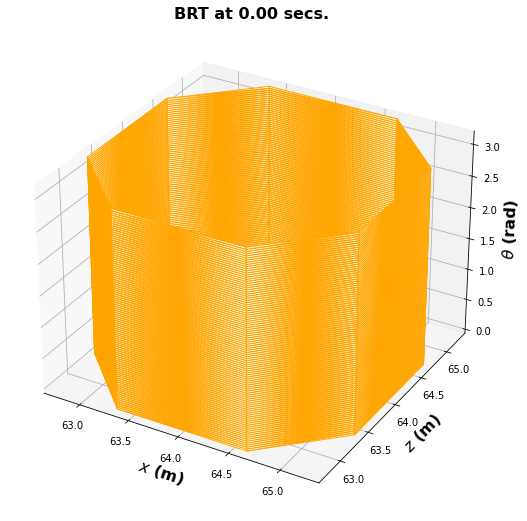

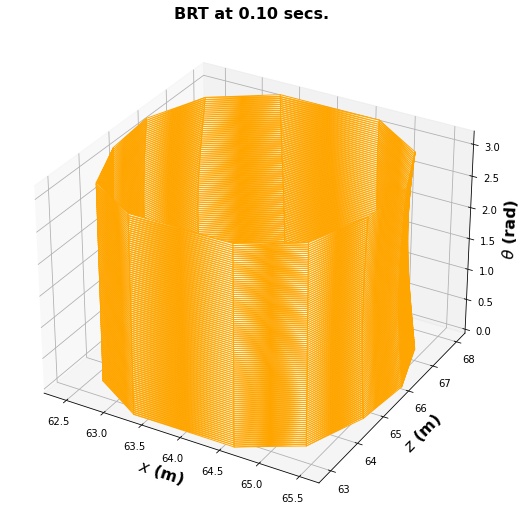

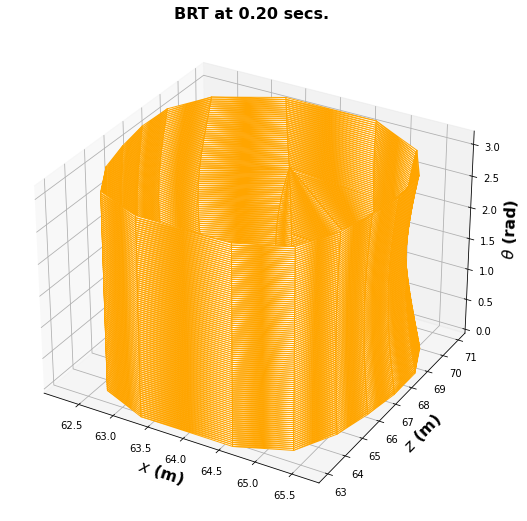

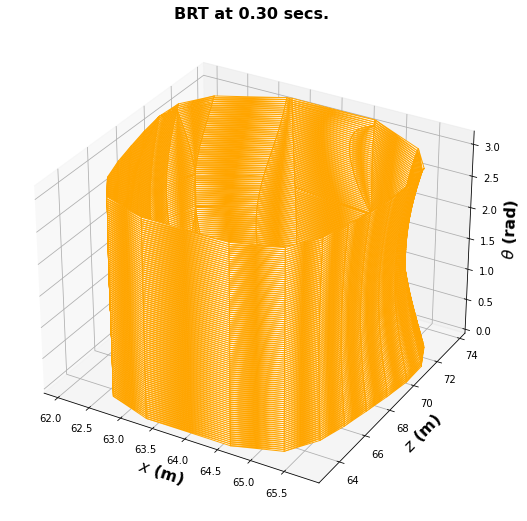

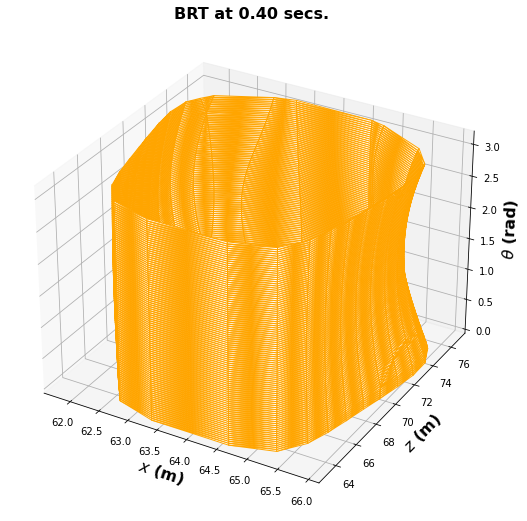

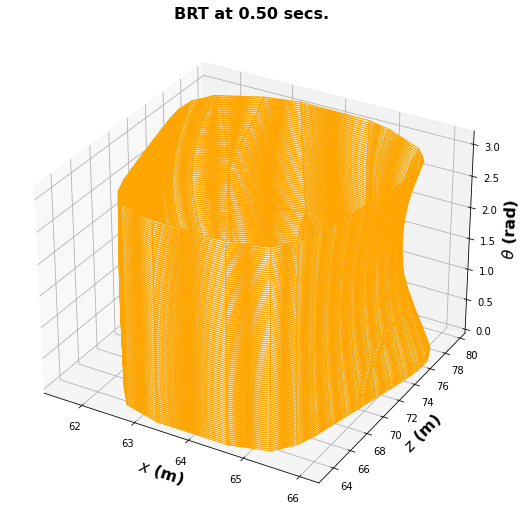

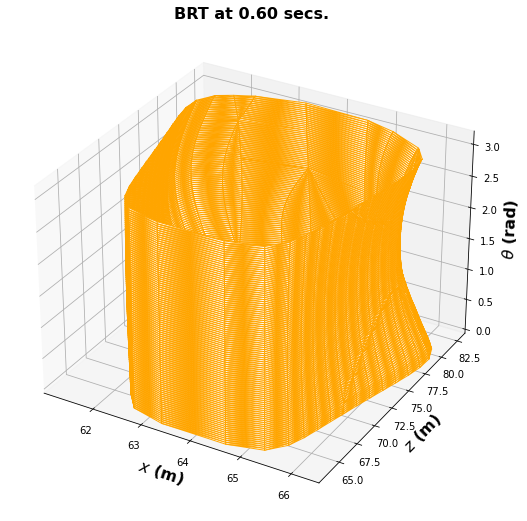

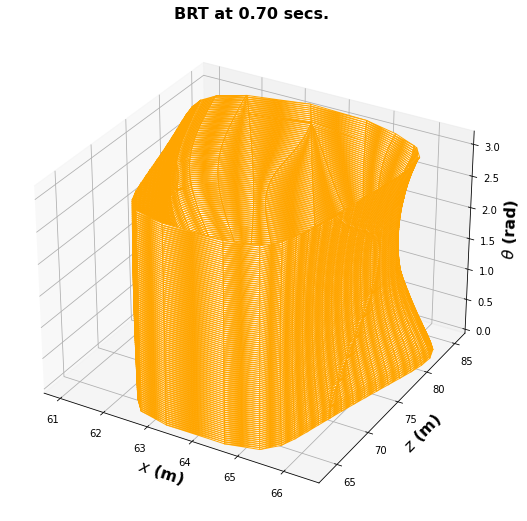

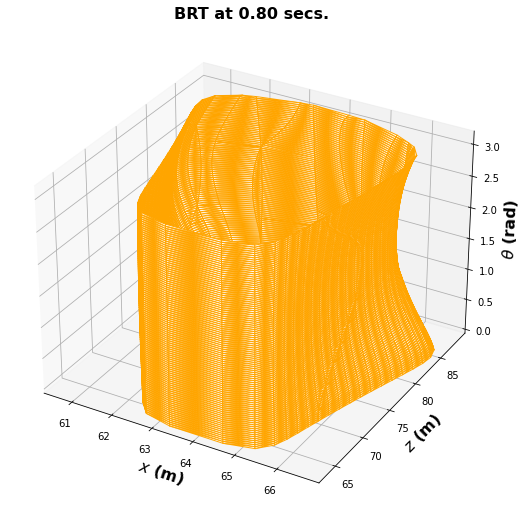

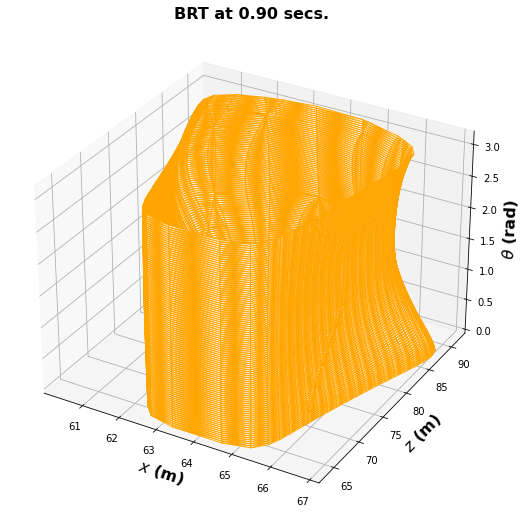

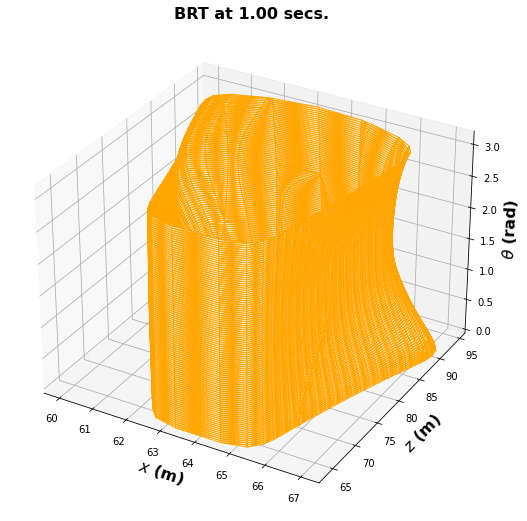

In [53]:
savepath= join("/opt/LevPy/Rockets")
import time 

for idx in range(brt.shape[0]):

    fig = plt.figure(figsize=(25,9))
    ax = fig.add_subplot(111, projection='3d')

    brt_this = brt[idx]
    time_this = brt_time[idx]

    
    mesh=implicit_mesh(brt_this, level=0, spacing=spacing,
                        edge_color='orange',  face_color='white')
    
    ax.add_collection3d(mesh.mesh)
    xlim, ylim, zlim = get_lims(mesh.verts)

    ax.set_xlim3d(*xlim)
    ax.set_ylim3d(*ylim)
    ax.set_zlim3d(*zlim)

    ax.set_xlabel(rf'$x$ (m)', fontdict=fontdict)
    ax.set_ylabel(rf'$z$ (m)', fontdict=fontdict)
    ax.set_zlabel(rf'$\theta$ (rad)',fontdict=fontdict)
    ax.set_title(f'BRT at {time_this:.2f} secs.', fontdict=fontdict)

    fig.canvas.draw()
    fig.canvas.flush_events()

    # plt.show()

    time.sleep(.1)

    print(time_this)
    fig = plt.gcf()
    fig.savefig(join(savepath, rf"rocket_{time_this:.2f}.jpg"), bbox_inches='tight',facecolor='None')
